In [36]:
# Import libraries
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)

# Volatility Surface
This notebook constructs a volatility surface from the ground up.

Input your index choice (NKY, SPX, HSI) here and click 'Run > Run all cells' to get the volatility surface of your index.

In [37]:
index = 'SPX' # Put your choice here

## 1. Initialisaiton
### 1.1. Parameters
Setting up necessary parameters and functions.

In [38]:
# Black-Scholes formula
def BS(type, S, K, r, q, vol, T):
    d1 = (np.log(S/K) + (r-q+vol**2/2)*T)/(vol*np.sqrt(T))
    d2 = d1 - vol*np.sqrt(T)
    if type=='C':
        return S*np.exp(-q*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*np.exp(-q*T)*norm.cdf(-d1)


# Bisection method for Black-Scholes formula
def Bisection_BS(V, BS, type, S, K, r, q, T, err):
    low = 0
    up = 1
    while BS(type, S, K, r, q, up, T) < V:
        up += 100
    while True:
        mid = (low+up)/2
        if BS(type, S, K, r, q, mid, T) > V:
            up = mid
        else:
            low = mid
        if abs(BS(type, S, K, r, q, mid, T)-V) < err:
            return mid
        elif mid < 0.01:
            return 0


# Calibration formula for volatility curve fitting
def Calibration(x, delta, kappa, gamma):
    sigmoid = 1/(1 + np.exp(-kappa*x))
    tanh = np.tanh(kappa*x)
    model = delta*tanh/kappa + gamma/2*(tanh/kappa)**2
    return model


# As of 01-Sep-2023
NKY = 32710.62
SPX = 4515.77
HSI = 18382.06

### 1.2. Risk Free Rate
Constructing risk free rate curves from data. 

In [39]:
df_JP = pd.read_csv('Run_Data/Risk Free Rate/JP_RF Rate_01092023.csv')
df_US = pd.read_csv('Run_Data/Risk Free Rate/US_RF Rate_01092023.csv')
df_HK = pd.read_csv('Run_Data/Risk Free Rate/HK_RF Rate_01092023.csv')
cs_JP = CubicSpline(df_JP['Days'],df_JP['Yield'])
cs_US = CubicSpline(df_US['Days'],df_US['Yield'])
cs_HK = CubicSpline(df_HK['Days'],df_HK['Yield'])

### 1.3. Customisation
Custom parameters based on your choic of index.

In [40]:
ddays = 504 # Number of days displayed in volatility surface
if index == 'NKY':
    S0 = NKY
    cs_rate = cs_JP
    ddays = 189
elif index == 'SPX':
    S0 = SPX
    cs_rate = cs_US
elif index == 'HSI':
    S0 = HSI
    cs_rate = cs_HK
else:
    print('No such index!')

## 2. Black-Scholes Volatility
Calculating Black-Scholes implied volatility.

In [41]:
df = pd.read_csv('Run_Data/Options/' + index + '_Calls_01092023.csv') # Load data
df.head()

,Maturity Date,Days,Strike,Bid,Ask,IMV
0,5/9/2023,4,4470,45.800003,48.199997,12.500000
1,5/9/2023,4,4475,41.100006,42.800003,11.376306
2,5/9/2023,4,4480,36.500000,38.699997,11.441755
3,5/9/2023,4,4485,32.100006,34.300003,11.185373
4,5/9/2023,4,4490,27.800003,28.600006,9.972991


In [42]:
df['Price'] = (df['Bid'] + df['Ask'])/2 # Calculate the mid price from bid and ask
df = df.loc[df['Price'] != 0] # Drop rows which have Price = 0
df['Interest Rate'] = cs_rate(df['Days'])
df['Moneyness'] = np.log(df['Strike']/S0)
df.head()

,Maturity Date,Days,Strike,Bid,Ask,IMV,Price,Interest Rate,Moneyness
0,5/9/2023,4,4470,45.800003,48.199997,12.500000,47.000000,5.237919,-0.010187
1,5/9/2023,4,4475,41.100006,42.800003,11.376306,41.950005,5.237919,-0.009069
2,5/9/2023,4,4480,36.500000,38.699997,11.441755,37.599998,5.237919,-0.007953
3,5/9/2023,4,4485,32.100006,34.300003,11.185373,33.200005,5.237919,-0.006837
4,5/9/2023,4,4490,27.800003,28.600006,9.972991,28.200005,5.237919,-0.005723


In [43]:
def BS_IMV(df):
    BS_IMV = []
    for i in range(df.shape[0]):
        T = df.iloc[i, df.columns.get_loc('Days')]/252
        V = df.iloc[i, df.columns.get_loc('Price')]
        K = df.iloc[i, df.columns.get_loc('Strike')]
        r = df.iloc[i, df.columns.get_loc('Interest Rate')]/100
        q = 0.03
        err = 0.01
        BS_IMV.append(Bisection_BS(V, BS, "C", S0, K, r, q, T, err))
    return BS_IMV

df['BS IMV'] = BS_IMV(df)

df = df.loc[df['BS IMV'] != 0]
df.head()

,Maturity Date,Days,Strike,Bid,Ask,IMV,Price,Interest Rate,Moneyness,BS IMV
2,5/9/2023,4,4480,36.500000,38.699997,11.441755,37.599998,5.237919,-0.007953,0.035645
3,5/9/2023,4,4485,32.100006,34.300003,11.185373,33.200005,5.237919,-0.006837,0.040771
4,5/9/2023,4,4490,27.800003,28.600006,9.972991,28.200005,5.237919,-0.005723,0.035889
5,5/9/2023,4,4495,23.800003,24.500000,9.850247,24.150002,5.237919,-0.004610,0.038940
6,5/9/2023,4,4500,20.000000,20.699997,9.728735,20.349998,5.237919,-0.003498,0.040527


### *Data Modifying

In [58]:
if index=='SPX':
    df.loc[df['Maturity Date']=='5/9/2023', 'BS IMV'] = (df.loc[df['Maturity Date']=='5/9/2023', 'IMV']/100)

if index=='HSI':
    df.loc[df['Maturity Date']=='1/9/2023', 'BS IMV'] = (df.loc[df['Maturity Date']=='1/9/2023', 'IMV']/100)
    df = df.loc[~(df['BS IMV'] >= 1)]
    df = df.loc[df['BS IMV'] != 0]

df.head()

,Maturity Date,Days,Strike,Bid,Ask,IMV,Price,Interest Rate,Moneyness,BS IMV
2,5/9/2023,4,4480,36.500000,38.699997,11.441755,37.599998,5.237919,-0.007953,0.114418
3,5/9/2023,4,4485,32.100006,34.300003,11.185373,33.200005,5.237919,-0.006837,0.111854
4,5/9/2023,4,4490,27.800003,28.600006,9.972991,28.200005,5.237919,-0.005723,0.099730
5,5/9/2023,4,4495,23.800003,24.500000,9.850247,24.150002,5.237919,-0.004610,0.098502
6,5/9/2023,4,4500,20.000000,20.699997,9.728735,20.349998,5.237919,-0.003498,0.097287


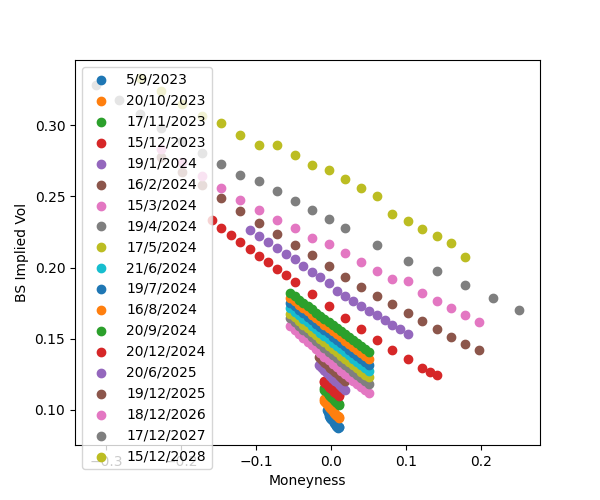

In [45]:
plt.figure(figsize=(6,5))
for i in df['Maturity Date'].unique():
    df_temp = df.loc[df['Maturity Date'] == i]
    plt.scatter(df_temp['Moneyness'], df_temp['BS IMV'], label=i)

plt.xlabel('Moneyness')
plt.ylabel('BS Implied Vol')
plt.legend()
plt.show()

## 3. Volatility Surface
### 3.1. Volatility Curve Calibration
Fitting calibrated curve to the Black-Scholes volatilty points for all maturity dates.

In [46]:
calibration = []
for date in df['Maturity Date'].unique():
    
    df_temp = df.loc[df['Maturity Date'] == date]
    K_atm = min(df_temp['Moneyness'], key = lambda x: abs(x))
    vol_atm = df_temp.loc[df['Moneyness'] == K_atm, 'BS IMV'].values[0]
    
    x = df_temp['Moneyness']
    
    y = df_temp['BS IMV']**2 - vol_atm**2
    
    popt, _ = curve_fit(Calibration, x, y)
    calibration.append((date, vol_atm, popt))

print(calibration)

[('5/9/2023', 0.09361872673, array([-2.84808569e-01,  2.36009805e-03,  3.86720412e+01])), ('20/10/2023', 0.1004638671875, array([ -0.12616936, -12.66036863,   1.97928893])), ('17/11/2023', 0.109100341796875, array([ -0.12104257, -17.60678021,   1.08757971])), ('15/12/2023', 0.114990234375, array([-0.11593253, -8.4124266 ,  0.73739655])), ('19/1/2024', 0.122467041015625, array([-0.12472914,  8.12980046,  2.24716147])), ('16/2/2024', 0.128570556640625, array([-0.12330255,  0.02071975,  2.03599316])), ('15/3/2024', 0.1322784423828125, array([-0.1224909 ,  6.37965624,  1.00816588])), ('19/4/2024', 0.138397216796875, array([-0.12472746,  5.99386024,  0.93950433])), ('17/5/2024', 0.1425628662109375, array([-0.12514513,  5.83631775,  0.86294007])), ('21/6/2024', 0.1471710205078125, array([-0.1260593 ,  5.88098328,  0.77423691])), ('19/7/2024', 0.1511993408203125, array([-0.12804716,  5.7048869 ,  0.74785233])), ('16/8/2024', 0.155242919921875, array([-0.12976575, -6.16423149,  0.72226994])), 

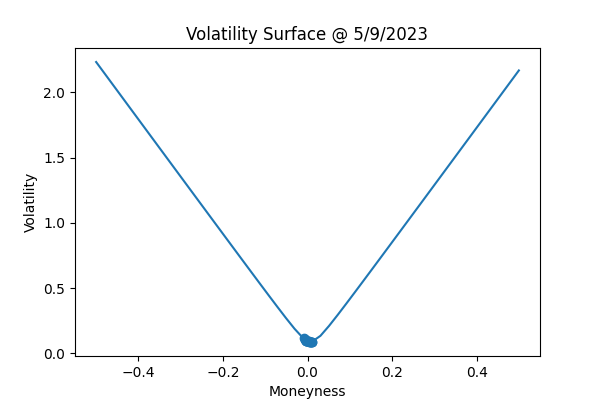

In [47]:
date = calibration[0][0]

i = np.where(df['Maturity Date'].unique()==date)[0][0]
mat_date = calibration[i][0]
vol2_atm = calibration[i][1]**2
delta, kappa, gamma = calibration[i][2]

plt.figure(figsize=(6,4))

df_plt = df.loc[df['Maturity Date'] == mat_date]
plt.scatter(df_plt['Moneyness'], df_plt['BS IMV'])

x = np.linspace(-0.5, 0.5, 50)
y = np.sqrt(Calibration(x, delta, kappa, gamma) + vol2_atm)

plt.plot(x,y)
plt.title('Volatility Surface @ ' + mat_date)
plt.xlabel('Moneyness')
plt.ylabel('Volatility')

plt.show()

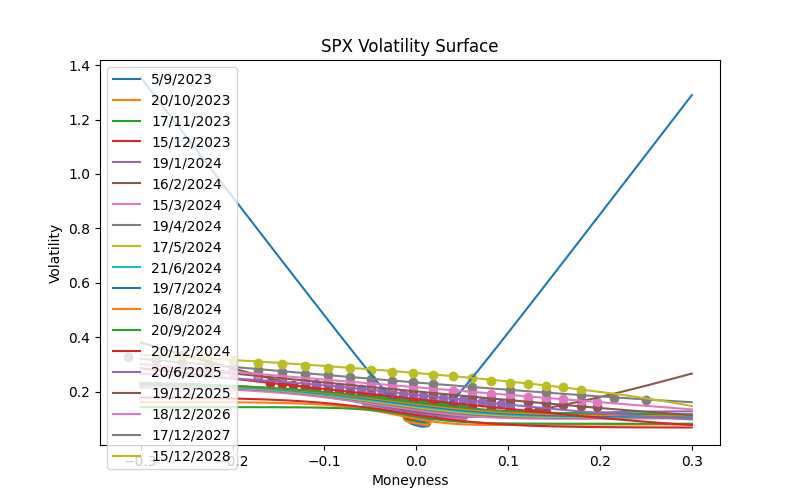

In [48]:
fig = plt.figure(figsize=(8,5))

for i, date in enumerate(df['Maturity Date'].unique()):
    
    df_plt = df.loc[df['Maturity Date'] == date]
    plt.scatter(df_plt['Moneyness'], df_plt['BS IMV'])
    
    mat_date = calibration[i][0]
    vol2_atm = calibration[i][1]**2
    delta, kappa, gamma = calibration[i][2]
    
    x = np.linspace(-0.3, 0.3, 50)
    y = np.sqrt(Calibration(x, delta, kappa, gamma) + vol2_atm)
    
    plt.plot(x, y, label=date)

plt.title(index + ' Volatility Surface')
plt.xlabel('Moneyness')
plt.ylabel('Volatility')
plt.legend()

plt.show()

### 3.2. Cubic Spline Interpolation
Fitting cubic spline to the Black-Scholes implied volatility points through different maturities of the same moneyness.

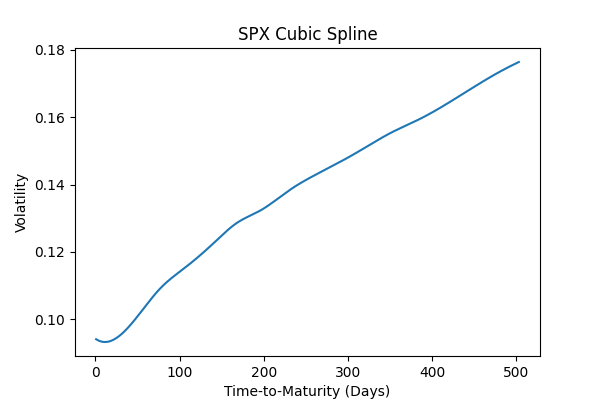

In [50]:
moneyness = 0

vols = []
days = []
for i, date in enumerate(df['Maturity Date'].unique()):
    vol2_atm = calibration[i][1]**2
    delta, kappa, gamma = calibration[i][2]
    
    vol = np.sqrt(Calibration(moneyness, delta, kappa, gamma) + vol2_atm)
    day = df.loc[df['Maturity Date'] == date, 'Days'].values[0]
    
    vols.append(vol)
    days.append(day)

cs_vol = CubicSpline(days, vols)

x = np.arange(1,ddays,1)

plt.figure(figsize=(6,4))
plt.plot(x, cs_vol(x),label='Moneyness = '+ str(moneyness))

plt.title(index + ' Cubic Spline')
plt.xlabel('Time-to-Maturity (Days)')
plt.ylabel('Volatility')

plt.show()

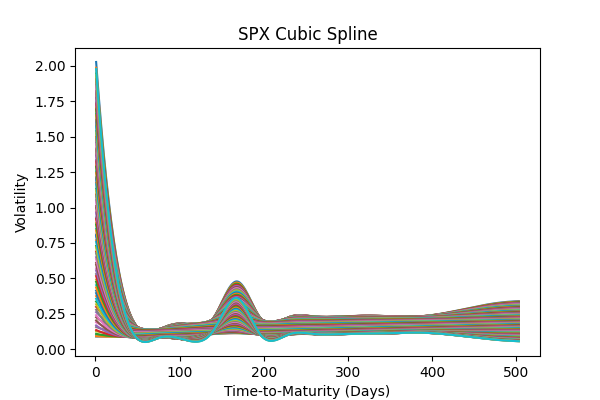

In [53]:
plt.figure(figsize=(6,4))

for moneyness in np.linspace(-0.4,0.4,100):
    vols = []
    days = []
    for i, date in enumerate(df['Maturity Date'].unique()):
        vol2_atm = calibration[i][1]**2
        delta, kappa, gamma = calibration[i][2]
        
        vol = np.sqrt(Calibration(moneyness, delta, kappa, gamma) + vol2_atm)
        day = df.loc[df['Maturity Date'] == date, 'Days'].values[0]
        
        vols.append(vol)
        days.append(day)

    cs_vol = CubicSpline(days, vols)
    
    x = np.arange(1,ddays,1)
    plt.plot(x, cs_vol(x),label='Moneyness = '+ str(moneyness))

plt.title(index + ' Cubic Spline')
plt.xlabel('Time-to-Maturity (Days)')
plt.ylabel('Volatility')

plt.show()


### 3.3. Volatility Surface Function
Create a function Volatility_Surf(moneyness, time_to_maturity) to output volatility of any moneyness and time-to-maturity.

In [54]:
def Volatility_Surf(moneyness, time_to_maturity):
    vols = []
    days = []
    for i, date in enumerate(df['Maturity Date'].unique()):
        vol2_atm = calibration[i][1]**2
        delta, kappa, gamma = calibration[i][2]
        
        vol = np.sqrt(Calibration(moneyness, delta, kappa, gamma) + vol2_atm)
        day = df.loc[df['Maturity Date'] == date, 'Days'].values[0]
        vols.append(vol)
        days.append(day)
    
    cs_vol = CubicSpline(days, vols)
    return cs_vol(time_to_maturity)

print(Volatility_Surf(0, ddays))

0.17653153128138102


## 4. Visualisation
A 3-d plot showing the volatility in relation to moneyness and time-to-maturity. The time-to-maturity shown for SPX and HSI is 504 days whereas for NKY is 189 days (shorter window due to lack of data).

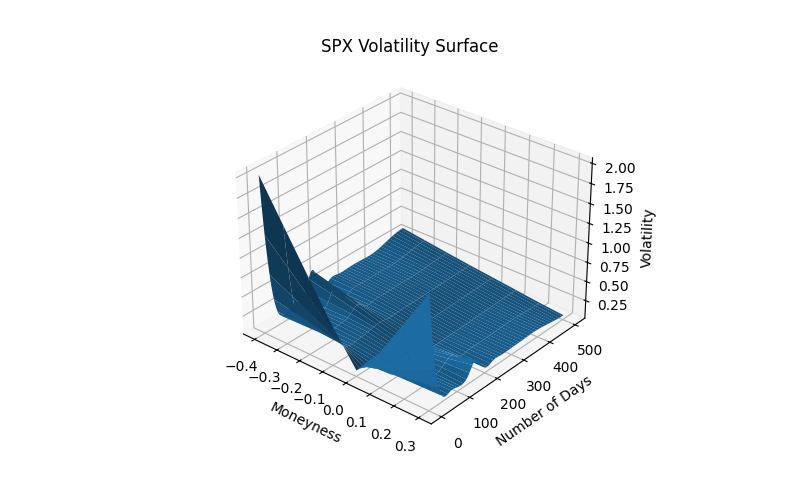

In [55]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
fig = plt.figure(figsize=(8,5))
ax = plt.axes(projection='3d')

x = np.arange(-0.4, 0.4, 0.1)
y = np.arange(1, ddays, 1)

X, Y = np.meshgrid(x, y)
Z = Volatility_Surf(x, y)

ax.plot_surface(X, Y, Z)
ax.set_title(index + ' Volatility Surface')
ax.set_xlabel('Moneyness')
ax.set_ylabel('Number of Days')
ax.set_zlabel('Volatility')

ax.view_init(elev=30, azim=-50, roll=0)

plt.show()